In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


In [2]:
train, test, submission = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv'), pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv'), pd.read_csv('/kaggle/input/playground-series-s5e10/sample_submission.csv')
train, test = train.drop(columns="id"), test.drop(columns="id")

In [3]:
train, test = pd.get_dummies(train, columns=['road_type', 'weather', 'time_of_day', 'lighting']), pd.get_dummies(test, columns=['road_type', 'weather', 'time_of_day', 'lighting'])

In [4]:
train_sample, test_sample = train.sample(5000), test.sample(5000)
y_sample = train_sample['accident_risk']

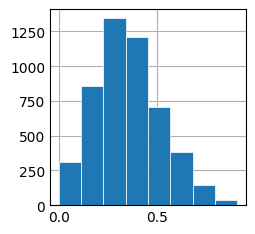

In [5]:
import matplotlib.pyplot as plt

plt.style.use('_mpl-gallery')
x_train_sample = train_sample['accident_risk']
fig, ax = plt.subplots()
ax.hist(x_train_sample, bins=8, linewidth=0.5, edgecolor="white")
plt.show()

In [6]:
scaler_features = train_sample.select_dtypes(include=["int64", "float64"])
scal_feats = [feat for feat in scaler_features.columns]

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
train_melted = train_sample.melt(
    value_vars=scal_feats,   # the numeric columns you want
    var_name="Variable",     # new column with the column names
    value_name="Value"       # new column with the values
)
print(train_melted)

            Variable  Value
0          num_lanes   3.00
1          num_lanes   1.00
2          num_lanes   4.00
3          num_lanes   3.00
4          num_lanes   1.00
...              ...    ...
24995  accident_risk   0.55
24996  accident_risk   0.62
24997  accident_risk   0.21
24998  accident_risk   0.43
24999  accident_risk   0.41

[25000 rows x 2 columns]


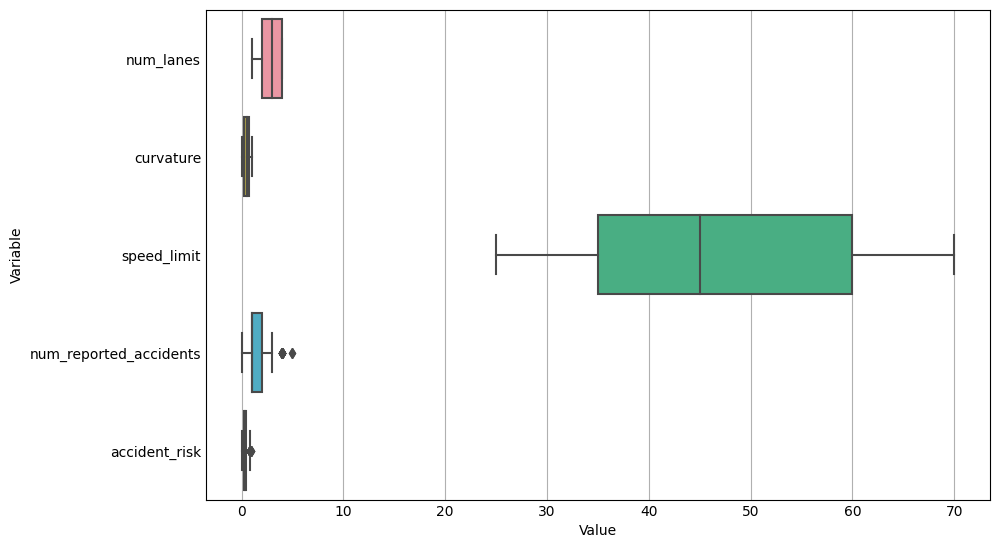

In [8]:
# Horizontal boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_melted, x="Value", y="Variable", orient="h")
plt.show()

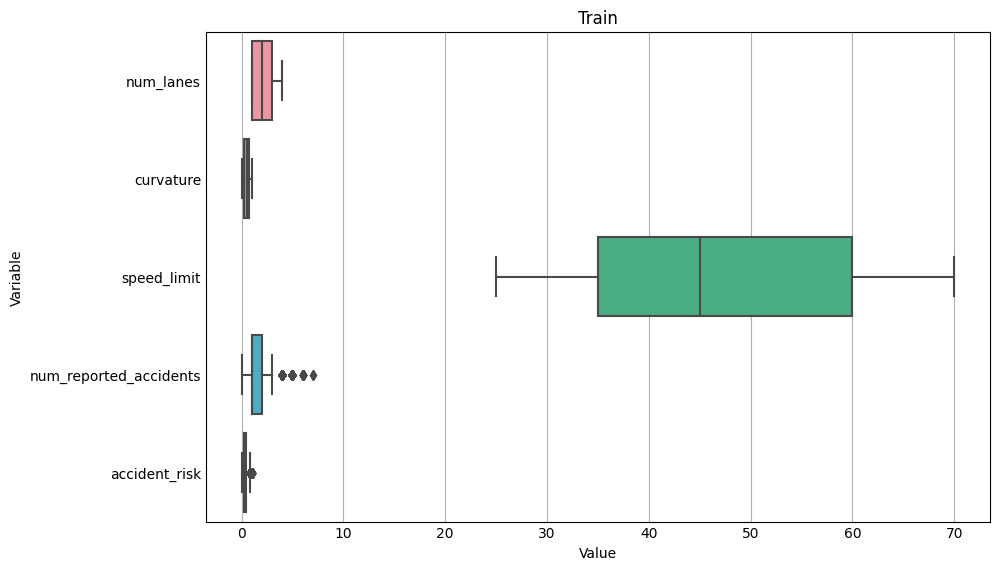

In [9]:
feats = train.select_dtypes(include=["int64", "float64"])
train_m = train.melt(
    value_vars=feats,   
    var_name="Variable",     
    value_name="Value"       
)
feats_t = test.select_dtypes(include=["int64","float64"])
test_m = test.melt(
    value_vars=feats_t,   
    var_name="Variable",     
    value_name="Value"      
)
plt.figure(figsize=(8, 5))
plt.title(label="Train")
sns.boxplot(data=train_m, x="Value", y="Variable", orient="h")
plt.show()

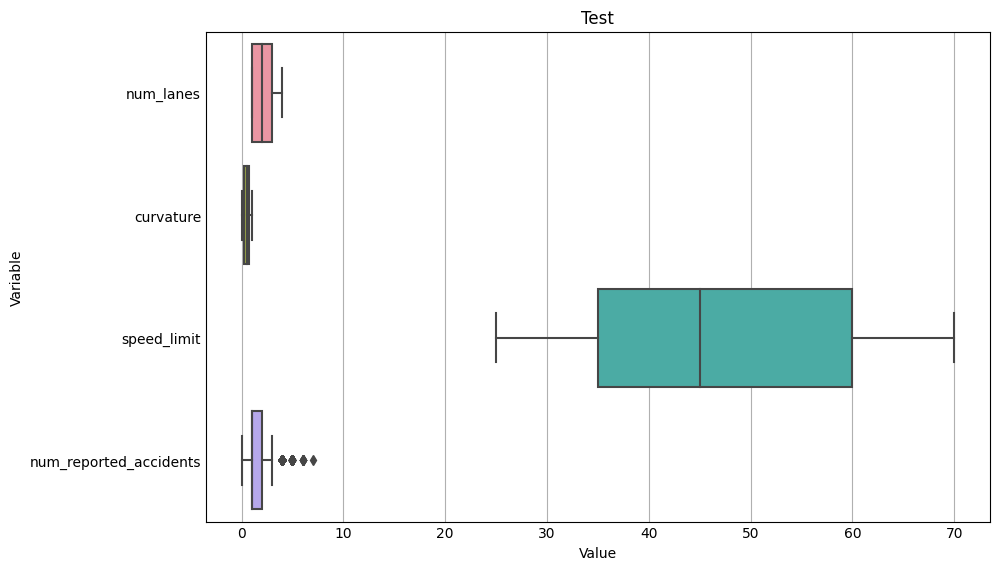

In [10]:
plt.figure(figsize=(8, 5))
plt.title(label="Test")
sns.boxplot(data=test_m, x="Value", y="Variable", orient="h")
plt.show()

In [11]:
print('len_train',len(train_m),'len_test', len(test_m))

len_train 2588770 len_test 690340


In [12]:
Q3_train = train['num_reported_accidents'].quantile(0.75)
Q1_train =  train['num_reported_accidents'].quantile(0.25) 
print('Q3: ',Q3_train, 'Q1: ', Q1_train)
IQR_train = Q3_train - Q1_train
lower, upper = Q1_train -(1.5 * IQR_train), Q3_train + (1.5 * IQR_train) 
print('IQRtrain: ', IQR_train, 'lower: ', lower, 'upper: ',upper)

Q3:  2.0 Q1:  1.0
IQRtrain:  1.0 lower:  -0.5 upper:  3.5


In [13]:
Q3_test = test['num_reported_accidents'].quantile(0.75)
Q1_test =  test['num_reported_accidents'].quantile(0.25) 
print('Q3: ',Q3_test, 'Q1: ', Q1_test)
IQR_test = Q3_test - Q1_test
lower_t, upper_t = Q1_test -(1.5 * IQR_test), Q3_test + (1.5 * IQR_test) 
print('IQR_test: ', IQR_test, 'lower: ', lower_t, 'upper: ',upper_t)

Q3:  2.0 Q1:  1.0
IQR_test:  1.0 lower:  -0.5 upper:  3.5


In [14]:
outlier_15_low_train = (train['num_reported_accidents'] < lower)
outliers_75_up_train = (train['num_reported_accidents'] > upper)
outlier_15_low_test = (test['num_reported_accidents'] < lower_t)
outliers_75_up_test = (test['num_reported_accidents'] > upper_t)

In [15]:
print('with outliers')
print('train: ', len(train))
print('test: ', len(test))
print('how many rows we will lose')
print('train \n',train['num_reported_accidents'][(outlier_15_low_train|outliers_75_up_train)])
print('test \n',test['num_reported_accidents'][(outlier_15_low_test|outliers_75_up_test)])


with outliers
train:  517754
test:  172585
how many rows we will lose
train 
 101       4
178       4
356       4
365       4
370       4
         ..
517029    6
517312    4
517430    4
517546    4
517549    4
Name: num_reported_accidents, Length: 2649, dtype: int64
test 
 165       4
223       6
308       4
661       4
1089      4
         ..
172145    4
172230    4
172288    4
172307    4
172490    4
Name: num_reported_accidents, Length: 925, dtype: int64


In [16]:
print('train_new \n',train['num_reported_accidents'][~(outlier_15_low_train|outliers_75_up_train)])
print('test_new \n',test['num_reported_accidents'][~(outlier_15_low_test|outliers_75_up_test)])
print(train.dtypes)

train_new 
 0         1
1         0
2         2
3         1
4         1
         ..
517749    2
517750    1
517751    0
517752    3
517753    2
Name: num_reported_accidents, Length: 515105, dtype: int64
test_new 
 0         1
1         0
2         1
3         2
4         3
         ..
172580    2
172581    2
172582    1
172583    0
172584    0
Name: num_reported_accidents, Length: 171660, dtype: int64
num_lanes                   int64
curvature                 float64
speed_limit                 int64
road_signs_present           bool
public_road                  bool
holiday                      bool
school_season                bool
num_reported_accidents      int64
accident_risk             float64
road_type_highway            bool
road_type_rural              bool
road_type_urban              bool
weather_clear                bool
weather_foggy                bool
weather_rainy                bool
time_of_day_afternoon        bool
time_of_day_evening          bool
time_of_day_morni

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import ipywidgets as widgets

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train)

MinMaxScaler()

In [18]:
train.head()

,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,num_reported_accidents,accident_risk,road_type_highway,...,road_type_urban,weather_clear,weather_foggy,weather_rainy,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,lighting_daylight,lighting_dim,lighting_night
0,2,0.06,35,False,True,False,True,1,0.13,False,...,True,False,False,True,True,False,False,True,False,False
1,4,0.99,35,True,False,True,True,0,0.35,False,...,True,True,False,False,False,True,False,True,False,False
2,4,0.63,70,False,True,True,False,2,0.30,False,...,False,True,False,False,False,False,True,False,True,False
3,4,0.07,35,True,True,False,False,1,0.21,True,...,False,False,False,True,False,False,True,False,True,False
4,1,0.58,60,False,False,True,False,1,0.56,False,...,False,False,True,False,False,True,False,True,False,False


<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

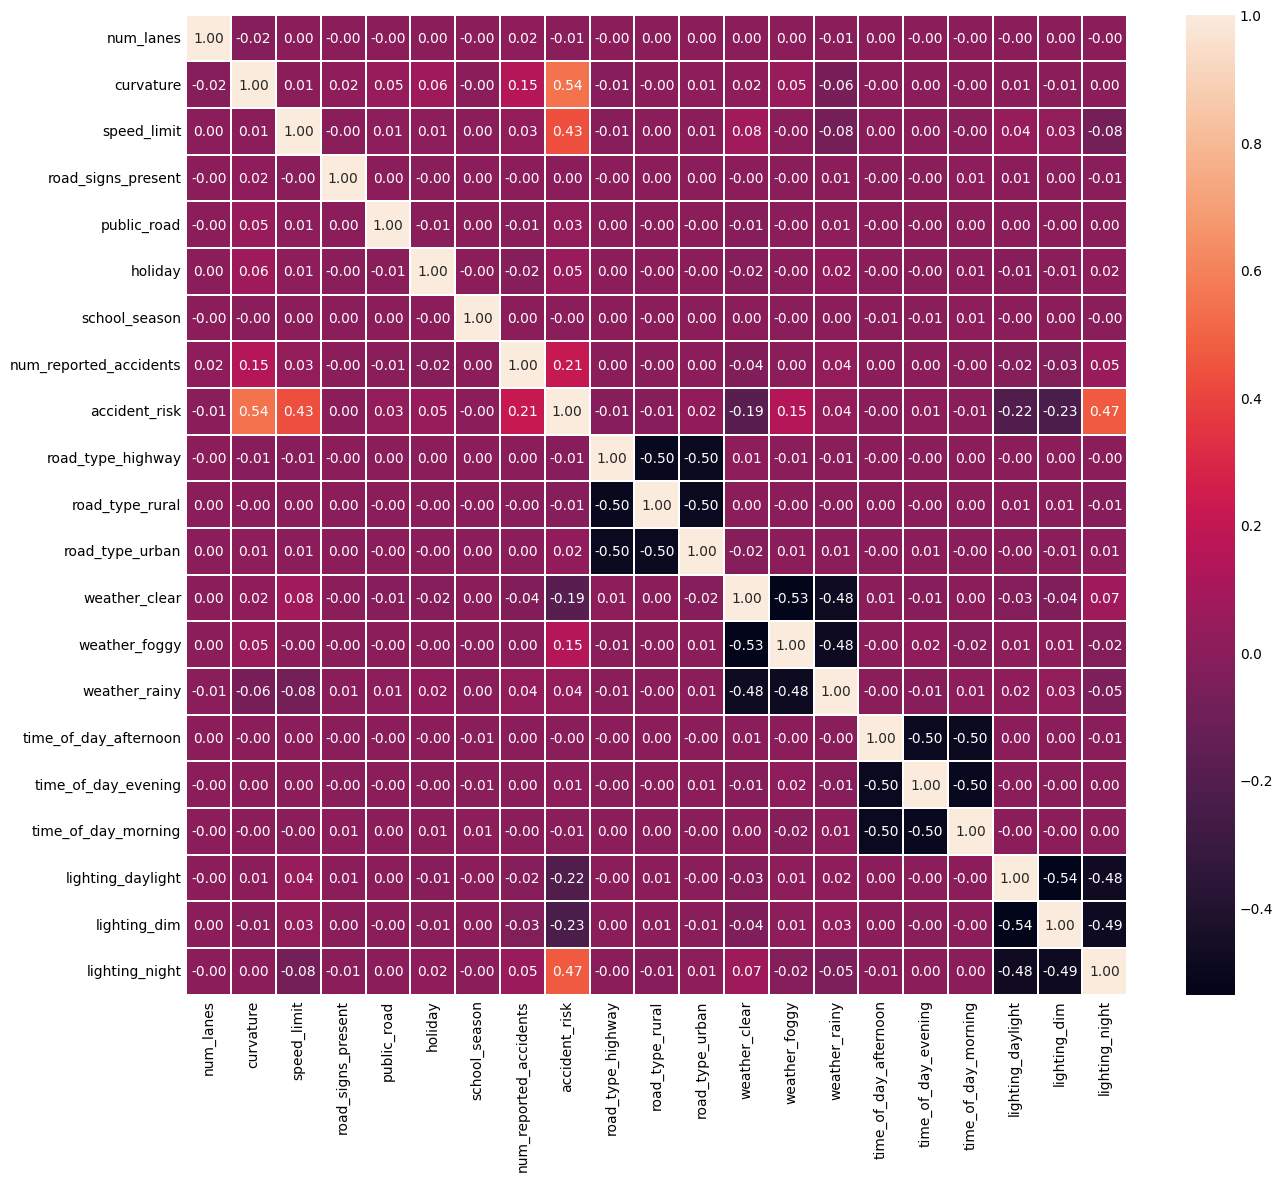

In [19]:
corr_mat = train.corr()
plt.figure(figsize=(12, 10))  # Width=12, Height=10 inches
sns.heatmap(corr_mat, annot=True,  linewidth=0.3, fmt=".2f");
plt.imshow

In [20]:
y = train['accident_risk']
train = train.drop(columns="accident_risk")

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
test_scaled = scaler.fit_transform(test)

(414203, 20) (103551, 20)


In [22]:
def pca_analysis(n_components):
    pca = PCA(n_components=n_components)
    pca.fit_transform(x_scaled)
    varianza = pca.explained_variance_ratio_
    sing_valu = pca.singular_values_
    print(f"Varianza explicada por PC1: {varianza[0]:.2%}")
    print(f"Varianza explicada por PC2: {varianza[1]:.2%}")
    print(f"Varianza total explicada: {varianza.sum():.2%}")
    print(f"Singular values: {sing_valu}")
    return pca
slider = widgets.IntSlider(value=2, min=1, max=8, step=1, description="Components:")
interactive_plot = widgets.interactive(pca_analysis, n_components=slider)
display(interactive_plot)


interactive(children=(IntSlider(value=2, description='Components:', max=8, min=1), Output()), _dom_classes=('w…

Varianza explicada por PC1: 8.00%
Varianza explicada por PC2: 7.72%
Varianza total explicada: 15.72%
Singular values: [813.9034594  799.96010324]
Varianza explicada por PC1: 7.97%
Varianza explicada por PC2: 7.72%
Varianza total explicada: 15.69%
Singular values: [812.7662193  799.66142247]
Varianza explicada por PC1: 8.00%
Varianza explicada por PC2: 7.72%
Varianza total explicada: 15.71%
Singular values: [813.83023518 799.65008141]


<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

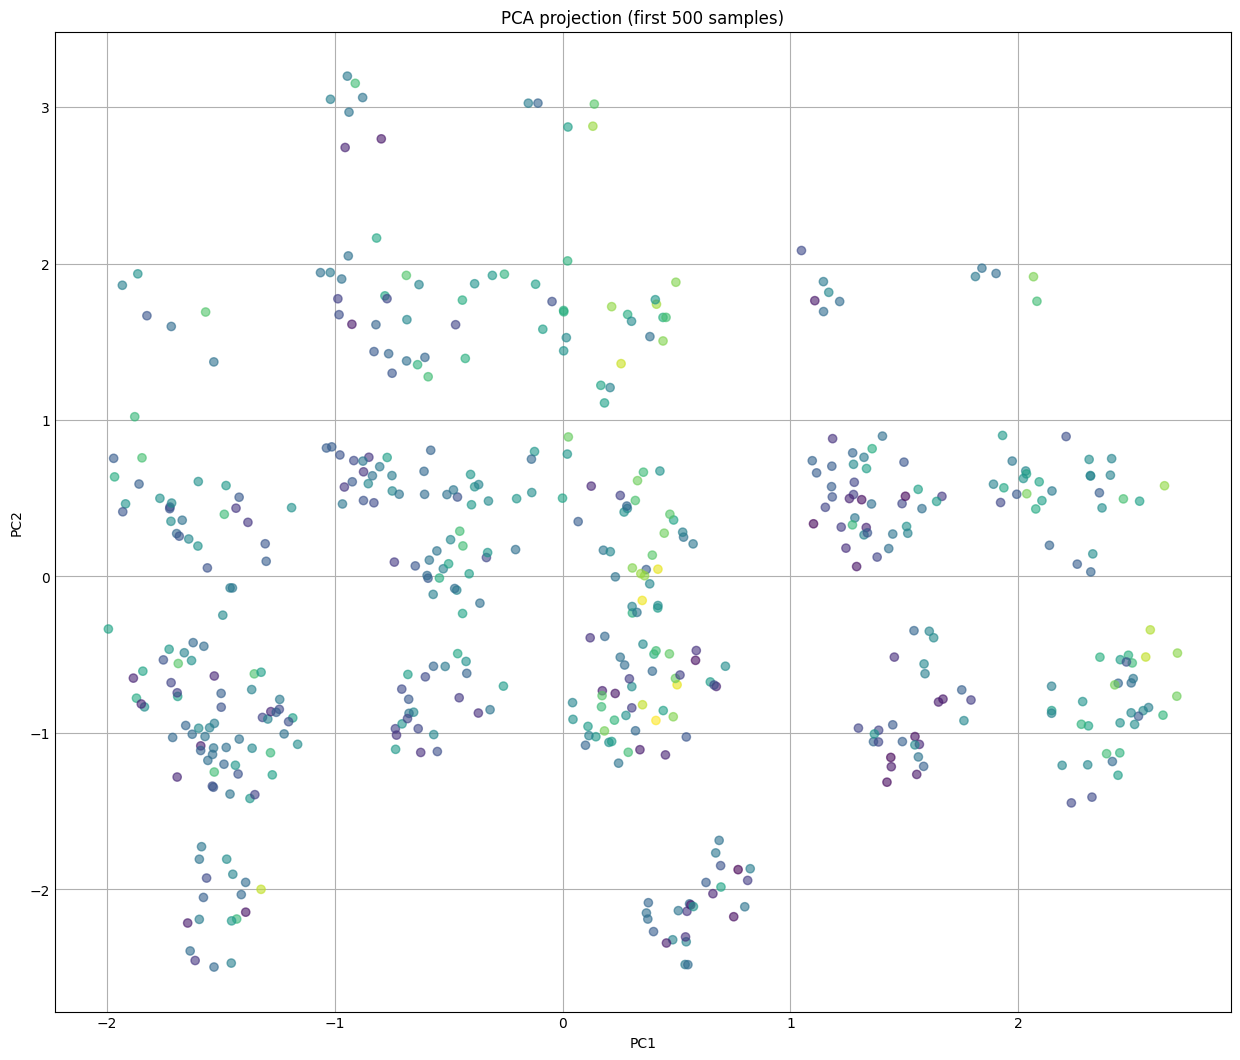

In [23]:
import matplotlib.pyplot as plt
x_train_pca = pca_analysis(2).fit_transform(x_scaled)
x_test_pca = pca_analysis(2).fit_transform(x_test_scaled)
test_pca = pca_analysis(2).fit_transform(test)
pca_1_sample = x_train_pca[:500, 0]
pca_2_sample = x_train_pca[:500, 1]
y_train_pca_sample = y_train[:500]
plt.figure(figsize=(12, 10))
plt.scatter(pca_1_sample, pca_2_sample, c=y_train_pca_sample, cmap='viridis', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA projection (first 500 samples)')
plt.imshow

In [24]:
eigenvectors = pca_analysis(2).components_
explained_variance_ratio = pca_analysis(2).explained_variance_ratio_
explained_variance = pca_analysis(2).explained_variance_ # These are the eigenvalues, representing variance along the PCs

Varianza explicada por PC1: 8.01%
Varianza explicada por PC2: 7.73%
Varianza total explicada: 15.74%
Singular values: [814.48746287 800.27027381]
Varianza explicada por PC1: 7.98%
Varianza explicada por PC2: 7.71%
Varianza total explicada: 15.69%
Singular values: [813.26301876 798.96215178]
Varianza explicada por PC1: 7.97%
Varianza explicada por PC2: 7.72%
Varianza total explicada: 15.69%
Singular values: [812.50117377 799.75794661]


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


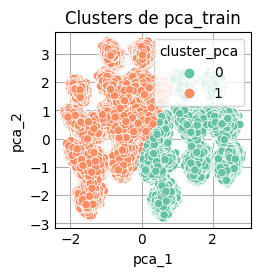

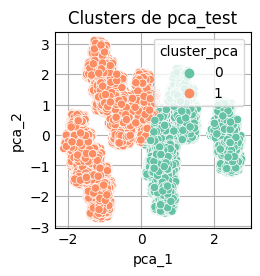

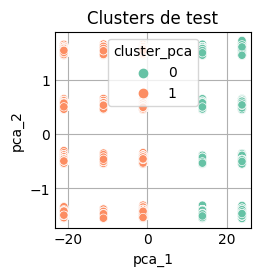

In [25]:
from sklearn.cluster import KMeans
x_train['pca_1'] = x_train_pca[:,0]
x_train['pca_2'] = x_train_pca[:,1]
x_test['pca_1'] = x_test_pca[:,0]
x_test['pca_2'] = x_test_pca[:,1]
test['pca_1'] = test_pca[:,0]
test['pca_2'] = test_pca[:,1
]
X = x_train[['pca_1', 'pca_2']]
X_test = x_test[['pca_1', 'pca_2']]
Test = test[['pca_1', 'pca_2']]

kmeans = KMeans(n_clusters=2, random_state=42)

x_train['cluster_pca'] = kmeans.fit_predict(X)

sns.scatterplot(x='pca_1', y='pca_2', hue='cluster_pca', palette='Set2', data=x_train)
plt.title("Clusters de pca_train")
plt.xlabel("pca_1")
plt.ylabel("pca_2")
plt.show()


x_test['cluster_pca'] = kmeans.predict(X_test)

sns.scatterplot(x='pca_1', y='pca_2', hue='cluster_pca', palette='Set2', data=x_test)
plt.title("Clusters de pca_test")
plt.xlabel("pca_1")
plt.ylabel("pca_2")
plt.show()

test['cluster_pca'] = kmeans.predict(Test)
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster_pca', palette='Set2', data=test)
plt.title("Clusters de test")
plt.xlabel("pca_1")
plt.ylabel("pca_2")
plt.show()

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

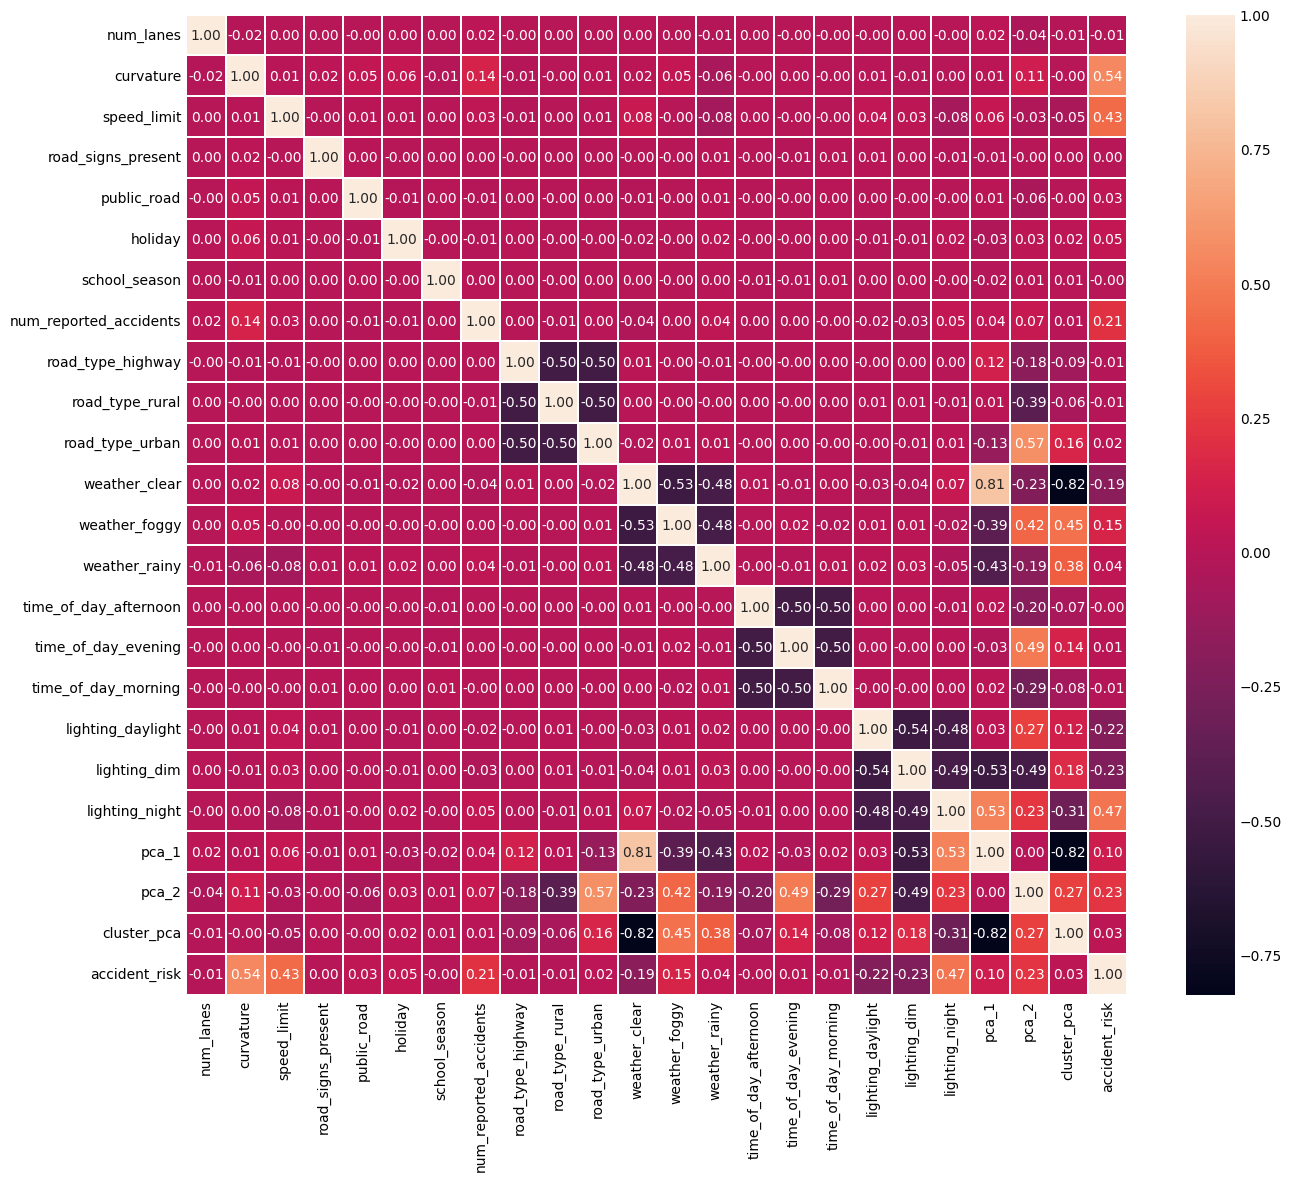

In [26]:
x_train['accident_risk'] = y_train
corr_mat_x_train = x_train.corr()
plt.figure(figsize=(12, 10))  # Width=12, Height=10 inches
sns.heatmap(corr_mat_x_train, annot=True,  linewidth=0.3, fmt=".2f");
plt.imshow

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


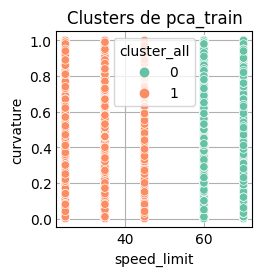

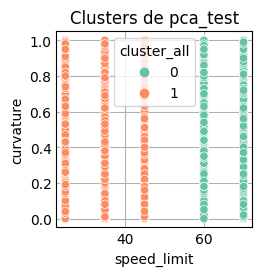

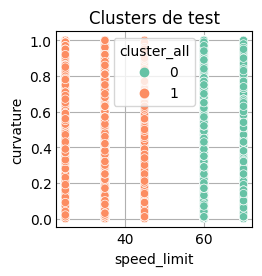

In [27]:
x_train = x_train.drop(columns='accident_risk')
X = x_train
X_test = x_test
Test = test

kmeans = KMeans(n_clusters=2, random_state=42)

x_train['cluster_all'] = kmeans.fit_predict(X)

sns.scatterplot(x='speed_limit', y='curvature', hue='cluster_all', palette='Set2', data=x_train)
plt.title("Clusters de pca_train")
plt.xlabel("speed_limit")
plt.ylabel("curvature")
plt.show()


x_test['cluster_all'] = kmeans.predict(X_test)

sns.scatterplot(x='speed_limit', y='curvature', hue='cluster_all', palette='Set2', data=x_test)
plt.title("Clusters de pca_test")
plt.xlabel('speed_limit')
plt.ylabel('curvature')
plt.show()

test['cluster_all'] = kmeans.predict(Test)
sns.scatterplot(x='speed_limit', y='curvature', hue='cluster_all', palette='Set2', data=test)
plt.title("Clusters de test")
plt.xlabel('speed_limit')
plt.ylabel('curvature')
plt.show()

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

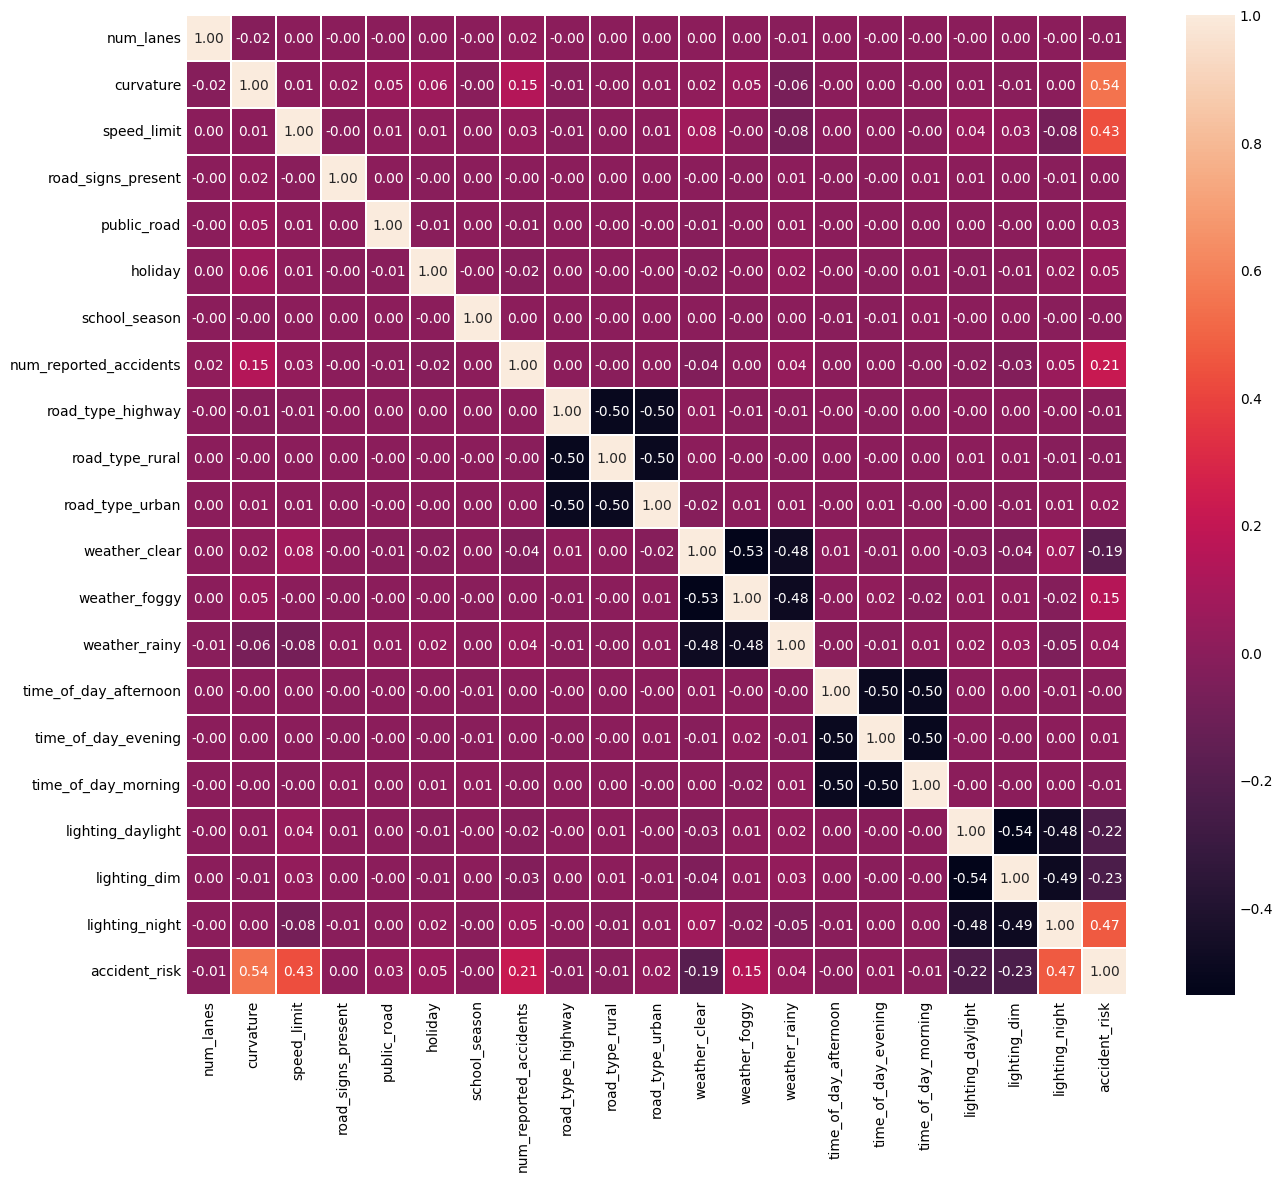

In [28]:
train['accident_risk'] = y_train
corr_mat_x_train = train.corr()
plt.figure(figsize=(12, 10))  # Width=12, Height=10 inches
sns.heatmap(corr_mat_x_train, annot=True,  linewidth=0.3, fmt=".2f");
plt.imshow

# **Feature Engineering and drop su useless labels corr coef**

In [29]:
drop_columns = ['cluster_pca', 'time_of_day_morning', 'time_of_day_evening', 'time_of_day_afternoon', 'road_type_urban', 'road_type_rural', 'road_type_highway', 'school_season', 'holiday', 'public_road', 'road_signs_present', 'num_lanes']
x_train = x_train.drop(columns =drop_columns)
x_test = x_test.drop(columns=drop_columns)
test = test.drop(columns = drop_columns)
x_train['curvature_over_speed'] = x_train['curvature'] / (x_train['speed_limit'] + 1e-5)
x_test['curvature_over_speed'] = x_test['curvature'] / (x_test['speed_limit'] + 1e-5)
test['curvature_over_speed'] = test['curvature'] / (test['speed_limit'] + 1e-5)

# interaction between curvature and reported accidents
x_train['curv_accidents'] = x_train['curvature'] * x_train['num_reported_accidents']
x_test['curv_accidents'] = x_test['curvature'] * x_test['num_reported_accidents']
test['curv_accidents'] = test['curvature'] * test['num_reported_accidents']

# ratio of night lighting influence over total lighting
x_train['night_ratio'] = x_train['lighting_night'] / (x_train['lighting_daylight'] + x_train['lighting_dim'] + 1e-5)
x_test['night_ratio'] = x_test['lighting_night'] / (x_test['lighting_daylight'] + x_test['lighting_dim'] + 1e-5)
test['night_ratio'] = test['lighting_night'] / (test['lighting_daylight'] + test['lighting_dim'] + 1e-5)
x_train['log_curvature'] = np.log1p(x_train['curvature'])
x_test['log_curvature'] = np.log1p(x_test['curvature'])
test['log_curvature'] = np.log1p(test['curvature'])

In [30]:
x_train['curv_times_speed']= x_train['curvature'] * x_train['speed_limit']
x_test['curv_times_speed'] = x_test['curvature'] * x_test['speed_limit']
test['curv_times_speed']= test['curvature'] * test['speed_limit']
x_train['accident_powered'] = x_train['curv_times_speed']**x_train['num_reported_accidents']
x_test['accident_powered']=x_test['curv_times_speed']**x_test['num_reported_accidents']
test['accident_powered'] = test['curv_times_speed']**test['num_reported_accidents']

In [31]:
print(x_train.isna().sum())
print(x_test.isna().sum())
print(test.isna().sum())

curvature                 0
speed_limit               0
num_reported_accidents    0
weather_clear             0
weather_foggy             0
weather_rainy             0
lighting_daylight         0
lighting_dim              0
lighting_night            0
pca_1                     0
pca_2                     0
cluster_all               0
curvature_over_speed      0
curv_accidents            0
night_ratio               0
log_curvature             0
curv_times_speed          0
accident_powered          0
dtype: int64
curvature                 0
speed_limit               0
num_reported_accidents    0
weather_clear             0
weather_foggy             0
weather_rainy             0
lighting_daylight         0
lighting_dim              0
lighting_night            0
pca_1                     0
pca_2                     0
cluster_all               0
curvature_over_speed      0
curv_accidents            0
night_ratio               0
log_curvature             0
curv_times_speed          0
acciden

In [32]:
scaler_X = StandardScaler()
x_train_scaled = scaler_X.fit_transform(x_train)
x_test_scaled = scaler_X.transform(x_test)
test_scaled = scaler_X.transform(test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print(x_train_scaled, x_train_scaled.shape, x_train.shape)

[[-0.21561748  0.87883453  0.90624745 ... -0.1213373   0.20946375
  -0.00453143]
 [-1.13341934 -1.33711289 -0.20965772 ... -1.14098783 -1.17581432
  -0.00453343]
 [-1.0599952   1.51196236 -0.20965772 ... -1.05180493 -0.55796729
  -0.0045334 ]
 ...
 [ 0.07807911  1.51196236  0.90624745 ...  0.16750994  0.8533254
  -0.00452959]
 [ 1.54656209  0.87883453  3.1380578  ...  1.41444652  2.0825158
   0.02238055]
 [ 1.06930512  0.87883453 -1.32556289 ...  1.04040905  1.57523087
  -0.00453344]] (414203, 18) (414203, 18)


In [33]:
# Check for any infinite values in the training data
x_np, x_test_np, test_np, y_np, y_test_np = (
    np.array(x_train_scaled), np.array(x_test_scaled),
    np.array(test_scaled), np.array(y_train_scaled),
    np.array(y_test_scaled)
)

In [34]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold


def k_fold_func(model, x_np, y_np):
    # Metrics lists
    rmse_list = []
    r2_list = []
    
    # Define KFold
    k_folds = KFold(n_splits=4, shuffle=True, random_state=42)
    models = {}
    # --- Cross-validation loop ---
    for fold, (train_idx, val_idx) in enumerate(k_folds.split(x_np)):
        X_train_fold, X_val_fold = x_np[train_idx], x_np[val_idx]
        y_train_fold, y_val_fold = y_np[train_idx], y_np[val_idx]
        
        # Fit Ridge model
        model = model.fit(X_train_fold, y_train_fold)
        
        # Predict
        y_pred = model.predict(X_val_fold)
        #oof_y_pred[val_idx] = y_pred
        # Metrics
        mse = mean_squared_error(y_val_fold, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_fold, y_pred)
        rmse_list.append(rmse)
        r2_list.append(r2)

        models[f'{fold}'] = model
        models[f'{fold}_y_pred'] = y_pred
        models[f'{fold}_rmse'] = rmse
        models[f'{fold}_r2'] = r2
        #models[f'{fold}_idx'] = oof_y_pred[val_idx]
        
        print(f"Fold {fold+1}: RMSE = {rmse:.4f}, MSE = {mse:.4f}, R² = {r2:.4f}")
    model_all = model.fit(x_np, y_np)
    # --- Mean metrics across folds ---
    print("\nAverage results across folds:")
    print(f"Mean MSE: {np.mean(rmse_list):.4f}")
    print(f"Mean R²:  {np.mean(r2_list):.4f}")
    return models, model_all

In [35]:
def differens(y_test_np, y_hat):
    diff = np.subtract(y_test_np, y_hat).flatten()
    plt.figure(figsize=(8,4))
    plt.plot(y_test_np[:500], label="True Values", marker='o', color='b')
    plt.plot(y_hat[:500], label="Predicted Values", marker='x', color='r')
    plt.bar(range(len(diff)), diff, alpha=0.4, label="Difference (True - Pred)")
    plt.axhline(0, color='black', linewidth=0.8)
    plt.legend()
    plt.title("Differences using np.subtract")
    plt.xlabel("Index")
    plt.ylabel("Value / Difference")
    plt.show()

In [36]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
cv = 8
# LassoCV to pick features
lasso = LassoCV(cv=cv, random_state=42, max_iter=10000).fit(x_np, y_np.ravel())
selector = SelectFromModel(lasso, prefit=True, threshold='mean')  # or a chosen threshold

X_reduced = selector.transform(x_np)
X_test_reduced = selector.transform(x_test_np)
test_reduced = selector.transform(test_np)
print("Selected features:", X_reduced.shape)

Selected features: (414203, 5)


# **Train the models**

In [37]:
ridge_models, ridge_model_all = k_fold_func(Ridge(alpha=10), X_reduced, y_np)

Fold 1: RMSE = 0.3623, MSE = 0.1313, R² = 0.8689
Fold 2: RMSE = 0.3630, MSE = 0.1318, R² = 0.8682
Fold 3: RMSE = 0.3639, MSE = 0.1324, R² = 0.8670
Fold 4: RMSE = 0.3652, MSE = 0.1334, R² = 0.8670

Average results across folds:
Mean MSE: 0.3636
Mean R²:  0.8678


In [38]:
random_forest_model = RandomForestRegressor(n_estimators=1000, criterion='squared_error', max_depth=100, min_samples_split=2, min_samples_leaf=2)
random_models, random_model_all = k_fold_func(random_forest_model, X_reduced, y_np.ravel())

Fold 1: RMSE = 0.3374, MSE = 0.1139, R² = 0.8863
Fold 2: RMSE = 0.3392, MSE = 0.1151, R² = 0.8849
Fold 3: RMSE = 0.3400, MSE = 0.1156, R² = 0.8839
Fold 4: RMSE = 0.3409, MSE = 0.1162, R² = 0.8841

Average results across folds:
Mean MSE: 0.3394
Mean R²:  0.8848


In [39]:
import xgboost 
params = {'objective': 'reg:squarederror','n_estimators': 1000,'learning_rate': 0.01,'max_depth': 100,'random_state': 42}
xgb = xgboost.XGBRegressor(**params)
xgb_models, xgb_model_all = k_fold_func(xgb, X_reduced, y_np)

Fold 1: RMSE = 0.3379, MSE = 0.1142, R² = 0.8860
Fold 2: RMSE = 0.3396, MSE = 0.1153, R² = 0.8847
Fold 3: RMSE = 0.3402, MSE = 0.1157, R² = 0.8838
Fold 4: RMSE = 0.3412, MSE = 0.1164, R² = 0.8839

Average results across folds:
Mean MSE: 0.3397
Mean R²:  0.8846


In [40]:
# unpack all models from hashtable models, random_models, xgb_models
# all prediction of this dictionary were made on X_test_reduced
ridge_model = ridge_models['0']
ridge_model_1 = ridge_models['1']
ridge_model_2 = ridge_models['2']
ridge_model_3 = ridge_models['3']
y_pred = ridge_models['0_y_pred']
y_pred_1 = ridge_models['1_y_pred']
y_pred_2 = ridge_models['2_y_pred']
y_pred_3 = ridge_models['3_y_pred']
random_model = random_models['0']
random_model_1 =random_models['1']
random_model_2 =random_models['2']
random_model_3 =random_models['3']
y_pred_random = random_models['0_y_pred']
y_pred_random_1 = random_models['1_y_pred']
y_pred_random_2 =random_models['2_y_pred']
y_pred_random_3 =random_models['3_y_pred']
#y_pred_random_idx = random_models['0_idx']
#y_pred_random_1_idx = random_models['1_idx']
#y_pred_random_2_idx =random_models['2_idx']
#y_pred_random_3_idx =random_models['3_idx']
xgb_model = xgb_models['0']
xgb_model_1 = xgb_models['1']
xgb_model_2 = xgb_models['2']
xgb_model_3 = xgb_models['3']
y_pred_xgb = xgb_models['0_y_pred']
y_pred_xgb_1 = xgb_models['1_y_pred']
y_pred_xgb_2 = xgb_models['2_y_pred']
y_pred_xgb_3 = xgb_models['3_y_pred']
#y_pred_xgb_idx = xgb_models['0_idx']
#y_pred_xgb_1_idx = xgb_models['1_idx']
#y_pred_xgb_2_idx = xgb_models['2_idx']
#y_pred_xgb_3_idx = xgb_models['3_idx']

In [41]:
ridge_x = ridge_model.predict(X_reduced)
ridge_x_1 = ridge_model_1.predict(X_reduced)
ridge_x_2 = ridge_model_2.predict(X_reduced)
ridge_x_3 = ridge_model_3.predict(X_reduced)
random_model_x = random_model.predict(X_reduced)
random_model_x_1 = random_model_1.predict(X_reduced)
random_model_x_2 = random_model_2.predict(X_reduced)
random_model_x_3 = random_model_3.predict(X_reduced)
xgb_model_x =  xgb_model.predict(X_reduced)
xgb_model_x_1 = xgb_model_1.predict(X_reduced)
xgb_model_x_2 = xgb_model_2.predict(X_reduced)
xgb_model_x_3 = xgb_model_3.predict(X_reduced)

# **New data created to train nn**

In [42]:
ridge_x_test = ridge_model.predict(X_test_reduced)
ridge_x_1_test = ridge_model_1.predict(X_test_reduced)
ridge_x_2_test = ridge_model_2.predict(X_test_reduced)
ridge_x_3_test = ridge_model_3.predict(X_test_reduced)
random_model_x_test = random_model.predict(X_test_reduced)
random_model_x_1_test = random_model_1.predict(X_test_reduced)
random_model_x_2_test = random_model_2.predict(X_test_reduced)
random_model_x_3_test = random_model_3.predict(X_test_reduced)
xgb_model_x_test =  xgb_model.predict(X_test_reduced)
xgb_model_x_1_test = xgb_model_1.predict(X_test_reduced)
xgb_model_x_2_test = xgb_model_2.predict(X_test_reduced)
xgb_model_x_3_test = xgb_model_3.predict(X_test_reduced)

In [43]:
ridge_test = ridge_model.predict(test_reduced)
ridge_1_test = ridge_model_1.predict(test_reduced)
ridge_2_test = ridge_model_2.predict(test_reduced)
ridge_3_test = ridge_model_3.predict(test_reduced)
random_model_test = random_model.predict(test_reduced)
random_model_1_test = random_model_1.predict(test_reduced)
random_model_2_test = random_model_2.predict(test_reduced)
random_model_3_test = random_model_3.predict(test_reduced)
xgb_model_test =  xgb_model.predict(test_reduced)
xgb_model_1_test = xgb_model_1.predict(test_reduced)
xgb_model_2_test = xgb_model_2.predict(test_reduced)
xgb_model_3_test = xgb_model_3.predict(test_reduced)

In [44]:
X_reduced_predicted_ridge = ridge_model_all.predict(X_reduced)
X_reduced_predicted_random = random_model_all.predict(X_reduced)
X_reduced_predicted_xgb = xgb_model_all.predict(X_reduced)
X_test_reduced_predicted_ridge = ridge_model_all.predict(X_test_reduced)
X_test_reduced_predicted_random = random_model_all.predict(X_test_reduced)
X_test_reduced_predicted_xgb = xgb_model_all.predict(X_test_reduced)
test_reduced_predicted_ridge = ridge_model_all.predict(test_reduced)
test_reduced_predicted_random = random_model_all.predict(test_reduced)
test_reduced_predicted_xgb = xgb_model_all.predict(test_reduced)

In [45]:
X_meta = np.column_stack([X_reduced, X_reduced_predicted_ridge, X_reduced_predicted_random, X_reduced_predicted_xgb])

X_meta_test = np.column_stack([X_test_reduced, X_test_reduced_predicted_ridge, X_test_reduced_predicted_random, X_test_reduced_predicted_xgb])

# **Neuronal Model trained with predicted data**

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

def create_nn_meta_model(input_dim):
    
    model = Sequential([
        
        Dense(units=8, activation='relu', input_shape=(input_dim,)),
        
        
        Dense(units=4, activation='relu'),
        
        
        Dense(units=1, activation='linear') 
    ])
    
    
    sgd_optimizer = SGD(
        learning_rate=0.01,
        momentum=0.0,
        nesterov=False,
        weight_decay=None,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
        use_ema=False,
        ema_momentum=0.99,
        ema_overwrite_frequency=None,
        loss_scale_factor=None,
        gradient_accumulation_steps=None,
        name='SGD'
    )
    
    model.compile(optimizer=sgd_optimizer, loss='mse', metrics=['mae'])
    return model

nn_meta_model = create_nn_meta_model(input_dim=X_reduced.shape[1])
nn_meta_model.summary()


history = nn_meta_model.fit(X_reduced, y_np, 
                  epochs=50, 
                 batch_size=32, 
                 verbose=0,
                 validation_data = (X_test_reduced, y_test_np))

2025-10-17 12:27:03.765655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760704024.039401      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760704024.114348      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-17 12:27:21.852811: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89 (356.00 B)

 Trainable params: 89 (356.00 B)

 Non-trainable params: 0 (0.00 B)

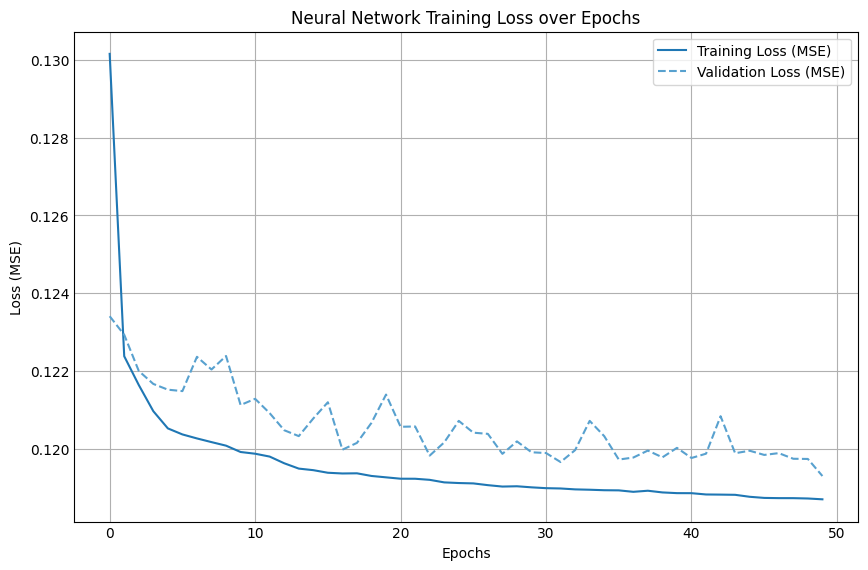

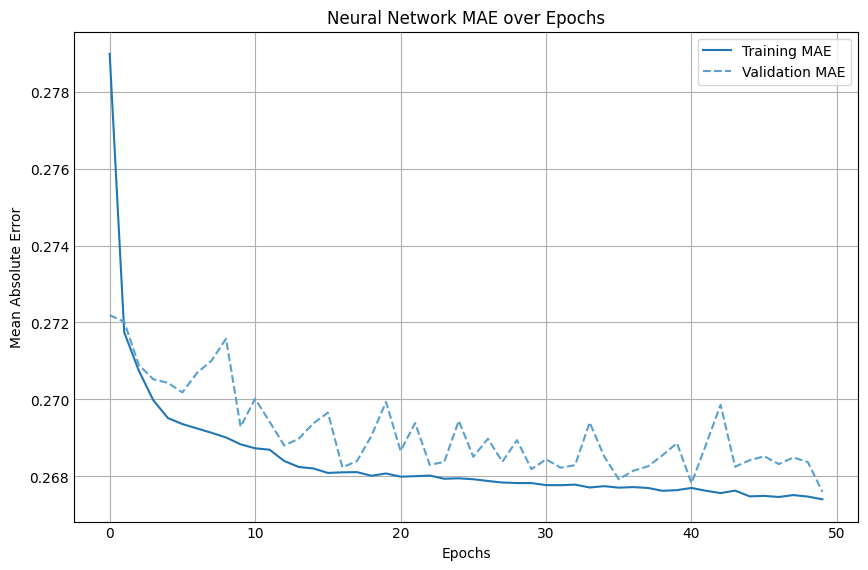

In [47]:
# --- Plot training curves ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', linestyle='--')

plt.title('Neural Network Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# --- (Optional) Plot MAE too ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Neural Network MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
test_meta = np.column_stack([test_reduced, test_reduced_predicted_ridge, test_reduced_predicted_random, test_reduced_predicted_xgb])

In [49]:
print(test_meta.shape)
print(X_meta.shape)

(172585, 8)
(414203, 8)


In [50]:
y_hat_nn_validation = nn_meta_model.predict(X_test_reduced).flatten()
y_hat_nn_test =  scaler_y.inverse_transform(nn_meta_model.predict(test_reduced))

3236/3236 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
5394/5394 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


--------------------------------- Ridge --------------------------------------


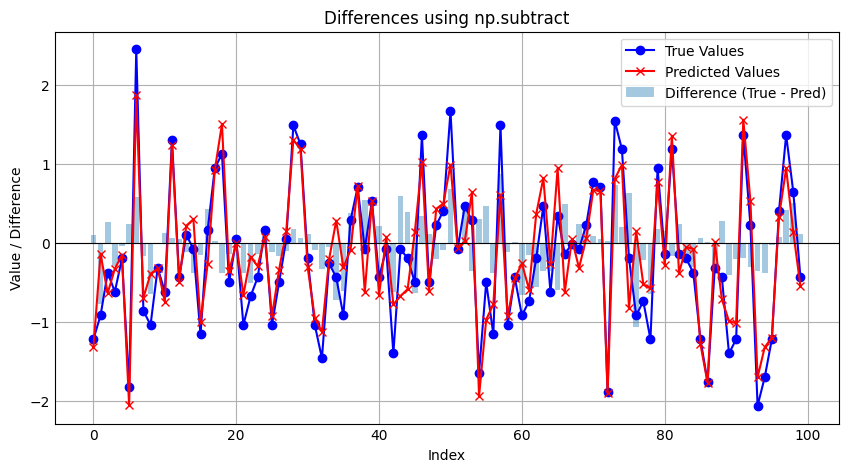

--------------------------------- Random --------------------------------------


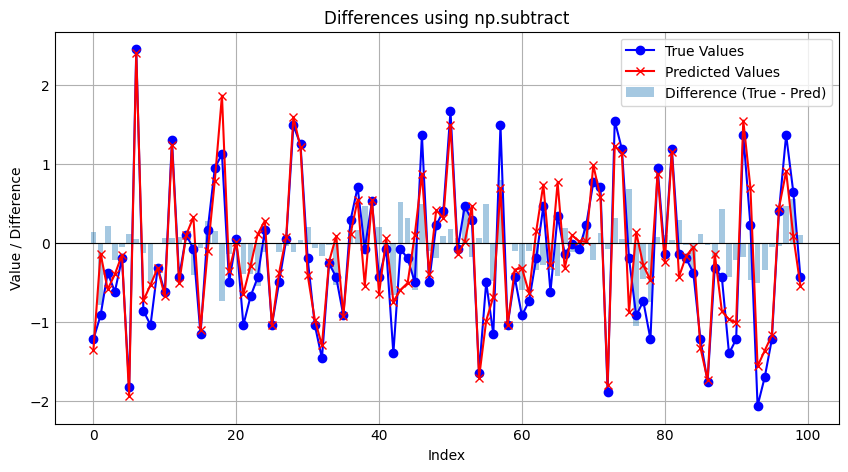

--------------------------------- Xgb --------------------------------------


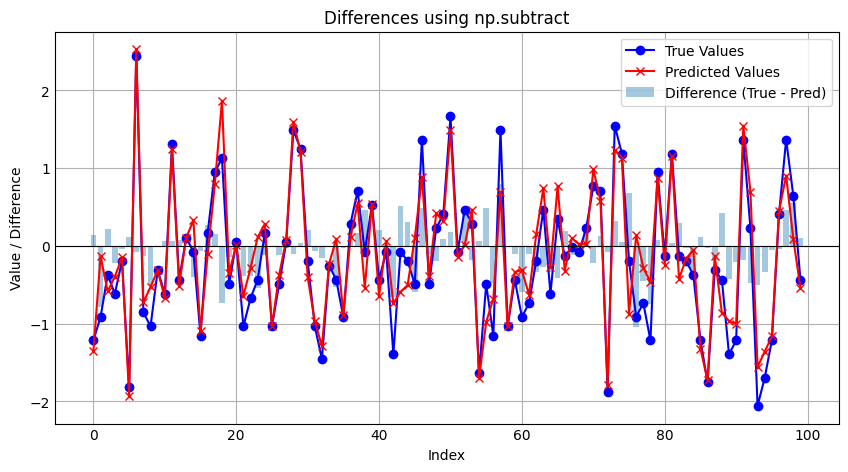

--------------------------------- NN --------------------------------------


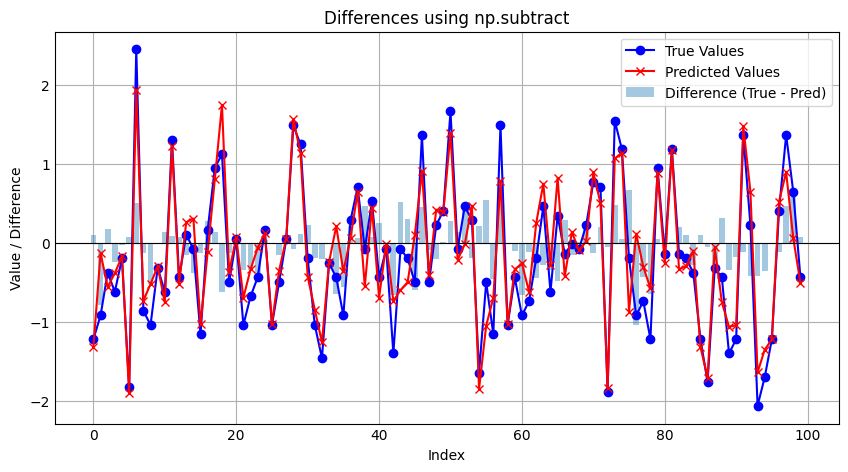

In [51]:
print('--------------------------------- Ridge --------------------------------------')
differens(y_test_np[:100], X_test_reduced_predicted_ridge[:100].reshape(-1,1))


print('--------------------------------- Random --------------------------------------')
differens(y_test_np[:100], X_test_reduced_predicted_random[:100].reshape(-1,1))

print('--------------------------------- Xgb --------------------------------------')
differens(y_test_np[:100], X_test_reduced_predicted_xgb[:100].reshape(-1,1))

print('--------------------------------- NN --------------------------------------')
differens(y_test_np[:100],y_hat_nn_validation[:100].reshape(-1,1))



In [52]:
from sklearn.linear_model import LinearRegression
# Train linear regression as meta-model
X_test_reduced_predicted = np.column_stack([X_test_reduced_predicted_ridge, X_test_reduced_predicted_random, X_test_reduced_predicted_xgb, y_hat_nn_validation])
test_reduced_predicted = np.column_stack([test_reduced_predicted_ridge, test_reduced_predicted_random, test_reduced_predicted_xgb, y_hat_nn_test])
meta_model = LinearRegression()
meta_model.fit(X_test_reduced_predicted, y_test_np)

predictions = meta_model.predict(test_reduced_predicted)
predictions = scaler_y.inverse_transform(predictions.reshape(-1,1))
ensambled = pd.DataFrame({'accident_risk_ensemble': predictions.reshape(-1)})

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_reduced_predicted_random, ensambled['accident_risk_ensemble']))
print(f"RMSE (Ensemble): {rmse:.5f}")

# Check model weights
print("Model Coefficients:", dict(zip(X.columns, meta_model.coef_)))
print("Intercept:", meta_model.intercept_)
print(ensambled)

RMSE (Ensemble): 0.88219
Model Coefficients: {'num_lanes': array([0.01851281, 0.62209834, 0.22438197, 0.1346515 ])}
Intercept: [-0.00068939]
        accident_risk_ensemble
0                     0.309633
1                     0.154726
2                     0.205759
3                     0.374919
4                     0.407755
...                        ...
172580                0.142018
172581                0.510459
172582                0.263377
172583                0.158292
172584                0.480675

[172585 rows x 1 columns]


In [53]:
y_hat_nn_test_n = scaler_y.inverse_transform(y_hat_nn_test.reshape(-1,1))
test_reduced_predicted_xgb = scaler_y.inverse_transform(test_reduced_predicted_xgb.reshape(-1,1))
test_reduced_predicted_ridge = scaler_y.inverse_transform(test_reduced_predicted_ridge.reshape(-1,1))
test_reduced_predicted_random = scaler_y.inverse_transform(test_reduced_predicted_random.reshape(-1,1))
submission['accident_risk'] = y_hat_nn_test_n
submission.to_csv('neuronal_model_sgd_lineal.csv', index=False)

In [54]:
submission['accident_risk_xgb'] = test_reduced_predicted_xgb
submission['accident_risk_ridge'] = test_reduced_predicted_ridge
submission['accident_risk_random'] = test_reduced_predicted_random
submission['accident_risk_liear_all'] = ensambled['accident_risk_ensemble']
submission.head(10)

,id,accident_risk,accident_risk_xgb,accident_risk_ridge,accident_risk_random,accident_risk_liear_all
0,517754,0.401475,0.295090,0.305249,0.295291,0.309633
1,517755,0.372628,0.121055,0.113429,0.121007,0.154726
2,517756,0.383991,0.177769,0.192612,0.177769,0.205759
3,517757,0.413252,0.367796,0.428534,0.367794,0.374919
4,517758,0.418662,0.407689,0.328738,0.407986,0.407755
5,517759,0.428786,0.465081,0.456299,0.465116,0.459898
6,517760,0.394809,0.267052,0.243254,0.267252,0.283854
7,517761,0.385825,0.191759,0.183491,0.191524,0.217534
8,517762,0.412907,0.370427,0.421661,0.370475,0.377004
9,517763,0.403017,0.327422,0.340832,0.327613,0.337862


In [55]:
drop_cols = ['accident_risk', 	'accident_risk_xgb', 	'accident_risk_ridge', 	'accident_risk_random']
submission = submission.drop(columns=drop_cols)
submission.columns = ['id', 'accident_risk']
submission.head()

,id,accident_risk
0,517754,0.309633
1,517755,0.154726
2,517756,0.205759
3,517757,0.374919
4,517758,0.407755


In [56]:
submission.to_csv('linear_regresion_all.csv', index=False)

In [57]:
#rmse_error_ridge = 0.05595
#rmse_error_random = 0.05596
#rmse_error_xgb = 0.05666
#rmse_error_nn =